In [19]:
from pathlib import Path
import re
import matplotlib.pyplot as plt

In [20]:
def load_texts(local_Illiad: str = '../data/Homer_Iliad.txt',
               local_Odyssey: str = '../data/Homer_Odyssey.txt',):
    """Load Wonderland and Looking-Glass texts from disk.

    Parameters
    ----------
    local_Illiad : str
        Path to Illiad text file. Defaults to '../data/Homer_Illiad.txt'.
    local_Odyssey : str
        Path to Odyssey text file. Defaults to '../data/Homer_Odyssey.txt'.

    Returns
    -------
    tuple[str, str]
        (illiad_text, odyssey_text).

    Raises
    ------
    FileNotFoundError
        If either file is missing.

    Extra Notes
    -----------
    - Using UTF-8 with `errors='ignore'` avoids codec exceptions on
      older Project Gutenberg dumps or inconsistent encodings.
    """
    p1, p2 = Path(local_Illiad), Path(local_Odyssey)

    # Fail fast with a clear message if a file is missing
    if not p1.exists():
        raise FileNotFoundError(
            f"Missing file: {p1}\n"
            "→ Please place 'Homer_Illiad.txt' at this path or update load_texts(...)."
        )
    if not p2.exists():
        raise FileNotFoundError(
            f"Missing file: {p2}\n"
            "→ Please place 'Homer_Odyssey.txt' at this path or update load_texts(...)."
        )

    # Read the files (UTF-8; ignore undecodable bytes to stay robust)
    illiad   = p1.read_text(encoding='utf-8', errors='ignore')
    odyssey = p2.read_text(encoding='utf-8', errors='ignore')
    return illiad, odyssey

In [21]:
def normalize(text: str) -> str:
    """Normalize a Gutenberg-like text for tokenization.

    Steps
    -----
    1) Heuristically strip Project Gutenberg headers/footers if present
       (looks for *** START ... *** END markers).
    2) Normalize newlines to '\n'.

    Parameters
    ----------
    text : str
        Raw text as loaded from disk (can be empty).

    Returns
    -------
    str
        Cleaned text suitable for tokenization and counting.
    """
    if not text:
        return ''
    # Clip to the main body if markers are present.
    start = text.find('By Homer')
    end   = text.find('THE END')
    if start != -1 and end != -1 and end > start:
        text = text[start:end]
    # Normalize Windows line endings.
    return text.replace('\r\n', '\n')


# -------- Tokenization helpers (simple) --------

WORD_RE = re.compile(r"[A-Za-z']+")  # keep apostrophes in words (e.g., don't -> don't)

def words(text: str):
    """Simple word tokenizer (lowercased, ASCII letters + apostrophes).

    Pros
    ----
    - Very fast and dependency-free.
    - Good enough for frequency/keyness demonstrations.

    Cons
    ----
    - No punctuation words, no sentence boundaries, no POS tags.
    - May treat possessives inconsistently across sources.

    Returns
    -------
    list[str]
        Lowercased word words.
    """
    return WORD_RE.findall(text.lower())

def loadDivineWords(local_actionWords: str = '../data/divineWords.txt'):
    p1 = Path(local_actionWords)

    if not p1.exists():
        raise FileNotFoundError(
            f"Missing file: {p1}\n"
            "→ Please place 'actionWords.txt' at this path or update load_texts(...)."
        )

    actionWords = p1.read_text(encoding='utf-8', errors='ignore')
    actionWords_normalized = normalize(actionWords)
    actionWords_words = words(actionWords_normalized)
    actionWords_hashmap = {word: 0 for word in actionWords_words}
    return actionWords_hashmap

def split_into_chapters(text: str, delimiter: str = "----------------------------------------------------------------------"):
    """Split text into chapters based on delimiter."""
    chapters = text.split(delimiter)
    # Filter out empty chapters
    return [ch.strip() for ch in chapters if ch.strip()]

def count_divine_words_by_chapter(chapters: list, divine_words_set: set) -> list:
    """Count divine words in each chapter."""
    chapter_counts = []
    for chapter in chapters:
        chapter_normalized = normalize(chapter)
        chapter_words = words(chapter_normalized)
        count = sum(1 for word in chapter_words if word in divine_words_set)
        chapter_counts.append(count)
    return chapter_counts

In [22]:
# Load raw texts
illiad_raw, odyssey_raw = load_texts()

# Normalize for tokenization
illiad = normalize(illiad_raw)
odyssey = normalize(odyssey_raw)

illiad_hash = loadDivineWords()
odyssey_hash = loadDivineWords()
print(f"Illiad chars: {len(illiad):,} | Odyssey chars: {len(odyssey):,}")

illiad_words = words(illiad)
odyssey_words = words(odyssey)

Illiad chars: 806,736 | Odyssey chars: 609,805


In [23]:
# Filling the hashmap of illiad
for word in illiad_words:
    if word in illiad_hash:
        illiad_hash[word] += 1

# Filling the hashmap of odyssey
for word in odyssey_words:
    if word in odyssey_hash:
        odyssey_hash[word] += 1

# Printing the illiad hash
print("illiad words:")
for word, value in illiad_hash.items():
    if value > 0:
        print(word, value)

print("odyssey words:")
# Printing the odyssey hash
for word, value in odyssey_hash.items():
    if value > 0:
        print(word, value)

illiad words:
god 117
gods 243
divine 3
fate 31
destiny 1
omen 6
prayer 30
sacrifice 27
altar 8
heaven 148
zeus 1
apollo 139
hades 47
nymph 5
muse 1
odyssey words:
god 93
gods 174
divine 9
fate 13
destiny 1
omen 7
prophecy 4
prayer 14
sacrifice 25
altar 7
heaven 165
apollo 28
hades 30
circe 30
calypso 33
nymph 7
muse 5


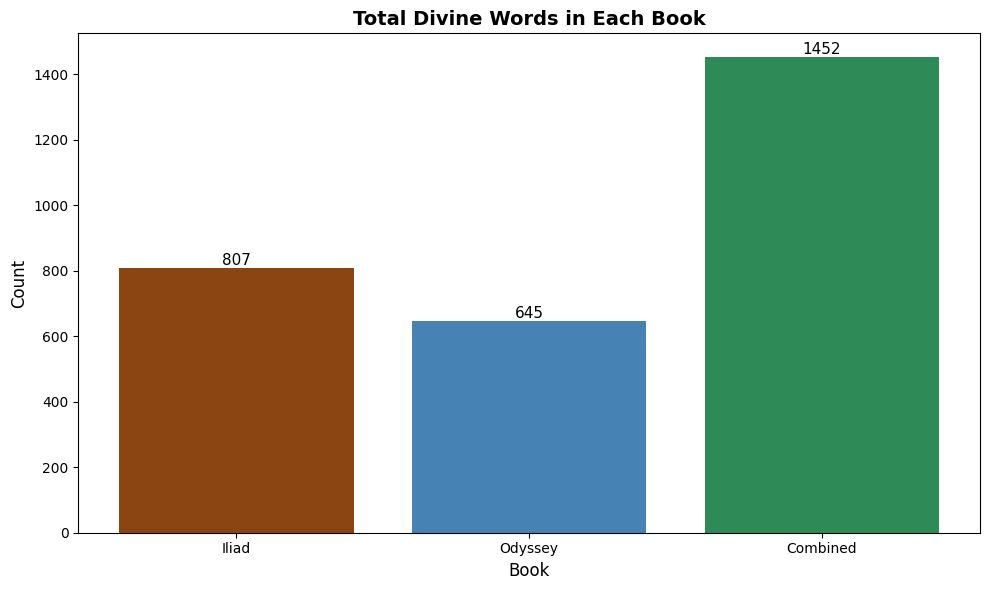

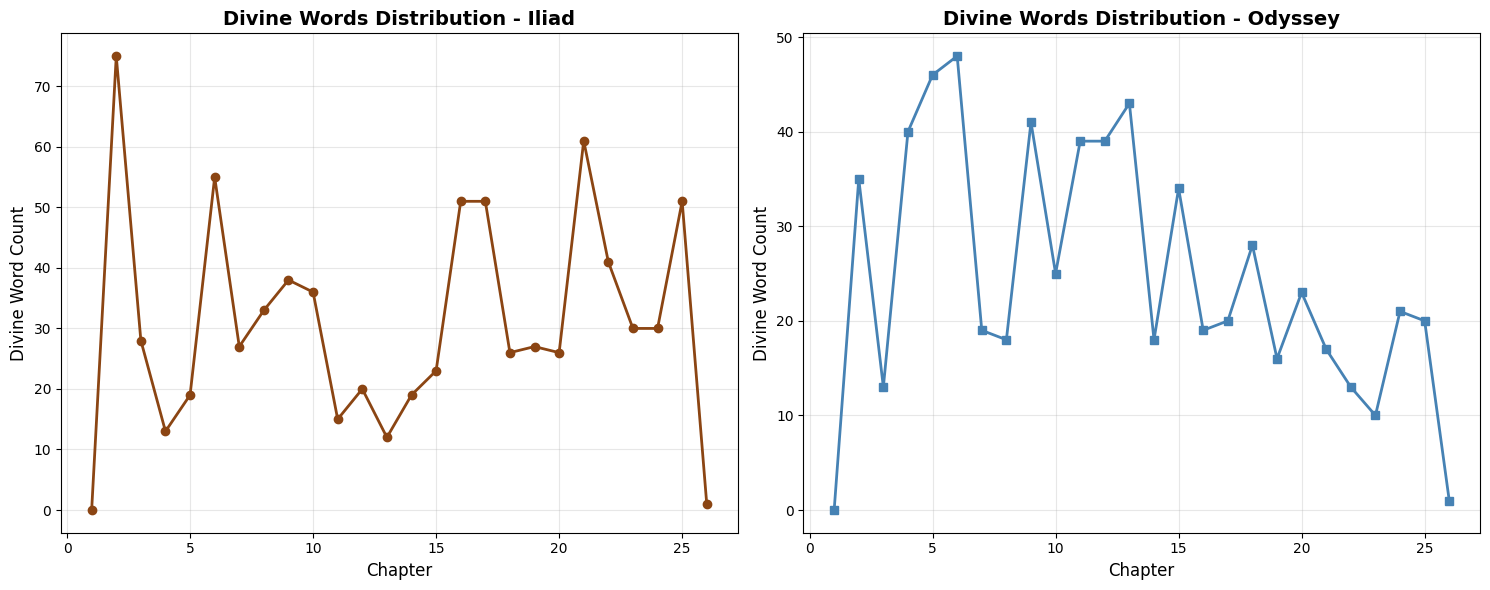

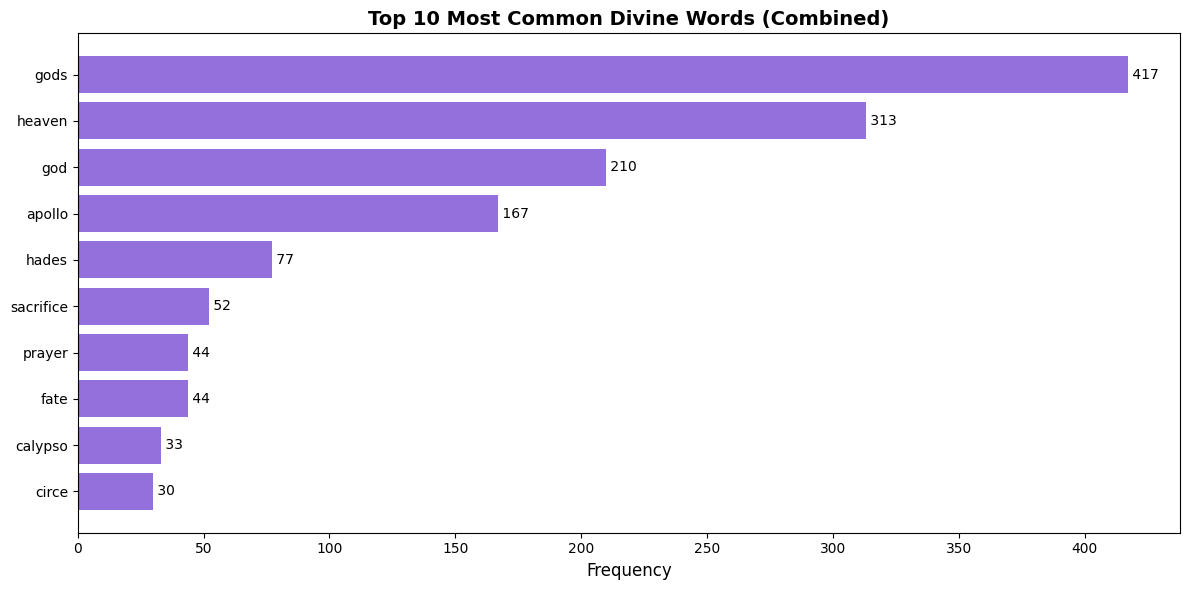

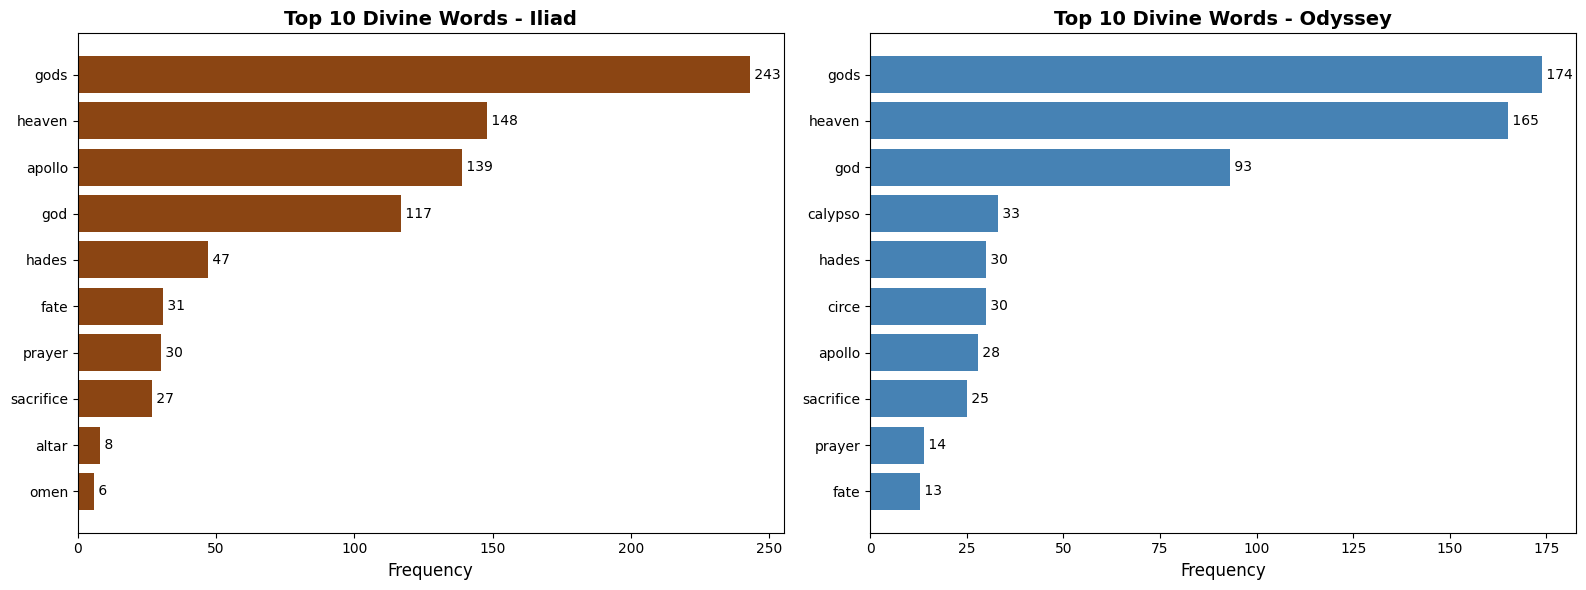

In [24]:
# ============ PLOTTING SECTION ============

# 1. Total divine words in each book and combined
illiad_total = sum(illiad_hash.values())
odyssey_total = sum(odyssey_hash.values())
combined_total = illiad_total + odyssey_total

plt.figure(figsize=(10, 6))
books = ['Iliad', 'Odyssey', 'Combined']
totals = [illiad_total, odyssey_total, combined_total]
bars = plt.bar(books, totals, color=['#8B4513', '#4682B4', '#2E8B57'])
plt.title('Total Divine Words in Each Book', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Book', fontsize=12)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

# 2. Distribution of divine words in chapters
divine_words_set = set(illiad_hash.keys())

illiad_chapters = split_into_chapters(illiad_raw)
odyssey_chapters = split_into_chapters(odyssey_raw)

illiad_chapter_counts = count_divine_words_by_chapter(illiad_chapters, divine_words_set)
odyssey_chapter_counts = count_divine_words_by_chapter(odyssey_chapters, divine_words_set)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Iliad chapters
ax1.plot(range(1, len(illiad_chapter_counts) + 1), illiad_chapter_counts,
         marker='o', linewidth=2, markersize=6, color='#8B4513')
ax1.set_title('Divine Words Distribution - Iliad', fontsize=14, fontweight='bold')
ax1.set_xlabel('Chapter', fontsize=12)
ax1.set_ylabel('Divine Word Count', fontsize=12)
ax1.grid(True, alpha=0.3)

# Odyssey chapters
ax2.plot(range(1, len(odyssey_chapter_counts) + 1), odyssey_chapter_counts,
         marker='s', linewidth=2, markersize=6, color='#4682B4')
ax2.set_title('Divine Words Distribution - Odyssey', fontsize=14, fontweight='bold')
ax2.set_xlabel('Chapter', fontsize=12)
ax2.set_ylabel('Divine Word Count', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Most common divine words (Combined)
combined_hash = {}
for word in divine_words_set:
    combined_hash[word] = illiad_hash[word] + odyssey_hash[word]

# Get top 10 most common divine words
top_words_combined = sorted(combined_hash.items(), key=lambda x: x[1], reverse=True)[:10]

if top_words_combined:
    words_list, counts_list = zip(*top_words_combined)

    plt.figure(figsize=(12, 6))
    bars = plt.barh(range(len(words_list)), counts_list, color='#9370DB')
    plt.yticks(range(len(words_list)), words_list)
    plt.xlabel('Frequency', fontsize=12)
    plt.title('Top 10 Most Common Divine Words (Combined)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()  # Most common at the top

    # Add value labels
    for i, (bar, count) in enumerate(zip(bars, counts_list)):
        plt.text(count, i, f' {count}', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("No divine words found in the texts.")

# 4. Most common divine words in each book (side by side)
top_words_illiad = sorted(illiad_hash.items(), key=lambda x: x[1], reverse=True)[:10]
top_words_odyssey = sorted(odyssey_hash.items(), key=lambda x: x[1], reverse=True)[:10]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Iliad top words
if top_words_illiad:
    words_i, counts_i = zip(*top_words_illiad)
    bars_i = ax1.barh(range(len(words_i)), counts_i, color='#8B4513')
    ax1.set_yticks(range(len(words_i)))
    ax1.set_yticklabels(words_i)
    ax1.set_xlabel('Frequency', fontsize=12)
    ax1.set_title('Top 10 Divine Words - Iliad', fontsize=14, fontweight='bold')
    ax1.invert_yaxis()

    # Add value labels
    for i, count in enumerate(counts_i):
        ax1.text(count, i, f' {count}', va='center', fontsize=10)

# Odyssey top words
if top_words_odyssey:
    words_o, counts_o = zip(*top_words_odyssey)
    bars_o = ax2.barh(range(len(words_o)), counts_o, color='#4682B4')
    ax2.set_yticks(range(len(words_o)))
    ax2.set_yticklabels(words_o)
    ax2.set_xlabel('Frequency', fontsize=12)
    ax2.set_title('Top 10 Divine Words - Odyssey', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()

    # Add value labels
    for i, count in enumerate(counts_o):
        ax2.text(count, i, f' {count}', va='center', fontsize=10)

plt.tight_layout()
plt.show()